In [4]:
import matplotlib.pyplot as plt
import numpy as np 
import json
from scipy import linalg

from common_utilities import generate_ssm, RandomState, rmse, plot_car_trajectory

In [5]:
#Parameters

q = 1.0  #process noise scalar
dt = 0.1 #Time step size 
s = 0.5  #Standard deviation of observation noise

M = 4 #State dimension: [x, y, vx, vy]
N = 2 #Observation dimension: [x, y]


# State transition matrix
# This explains/models how the state evolves over time 
# assuming that there is a constant velicity within the 2d space
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

#Process noise covariance matrix
#models the uncertainty in the state evolution
Q = q * np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0],
                  [0, dt **3 / 3, 0, dt ** 2 / 2],
                  [dt ** 2 / 2, 0, dt, 0],
                  [0, dt ** 2 / 2, 0, dt]])

#Observation Matrix, maps full state to the observed positon
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

#observation noise covariance matrix
R = np.array([[s ** 2, 0],
              [0, s ** 2]])

#Initial state
#Position is at (0,0), velocity is at (1, -1)
x_0 = np.array([0., 0., 1., -1.])

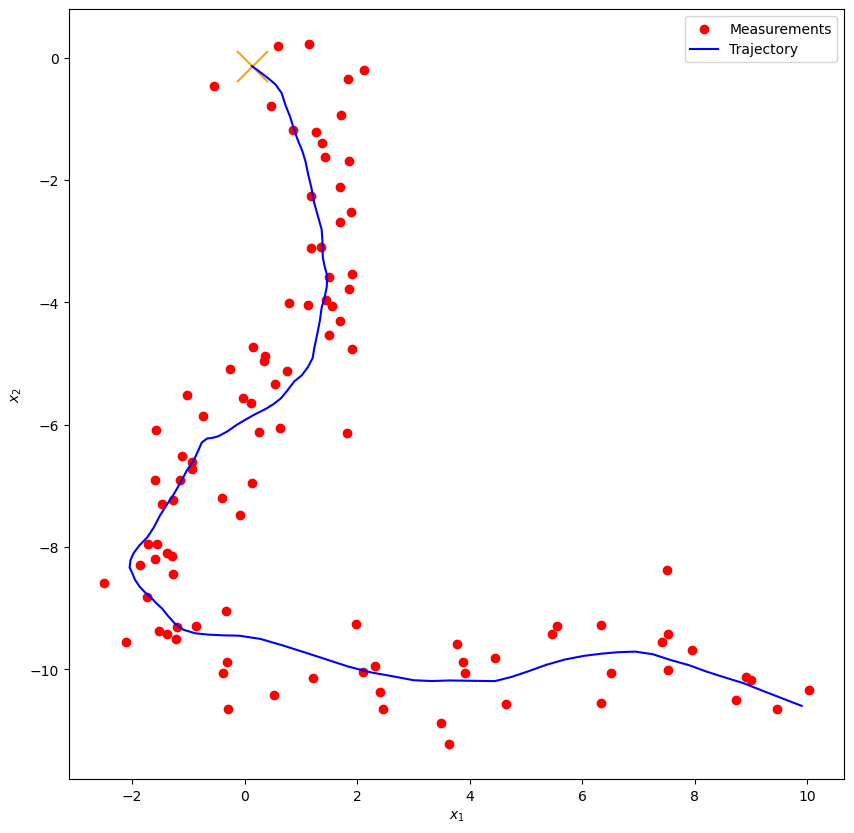

In [6]:
#loading data from file
with open("car_track.json") as fp:
    jsondata = json.load(fp)
    states = np.array(jsondata["X"]).T
    observations = np.array(jsondata["Y"]).T
    steps = states.shape[0]

plot_car_trajectory(observations, states, "Trajectory")

 Innovation trigger at timestep 1. Innovation norm = 2.262
 Innovation trigger at timestep 3. Innovation norm = 1.481
 Innovation trigger at timestep 5. Innovation norm = 1.393
 Innovation trigger at timestep 8. Innovation norm = 1.259
 Innovation trigger at timestep 10. Innovation norm = 1.207
 Innovation trigger at timestep 14. Innovation norm = 1.940
 Innovation trigger at timestep 19. Innovation norm = 1.069
 Innovation trigger at timestep 20. Innovation norm = 1.230
 Innovation trigger at timestep 25. Innovation norm = 1.057
 Innovation trigger at timestep 28. Innovation norm = 1.838
 Innovation trigger at timestep 29. Innovation norm = 1.548
 Innovation trigger at timestep 37. Innovation norm = 1.377
 Innovation trigger at timestep 40. Innovation norm = 1.317
 Innovation trigger at timestep 41. Innovation norm = 1.453
 Innovation trigger at timestep 43. Innovation norm = 1.403
 Innovation trigger at timestep 46. Innovation norm = 1.037
 Innovation trigger at timestep 52. Innovati

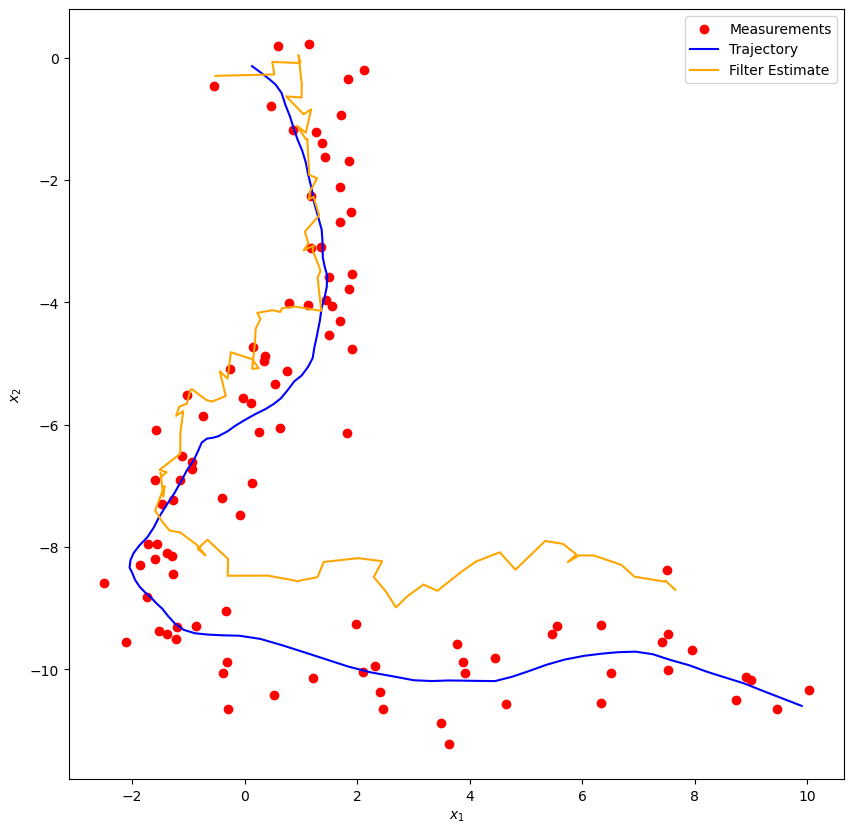

In [10]:
#implementation of kalman filter
def kalman_filter_innov(m_0, P_0, A, Q, H, R, observations):
    M = m_0.shape[-1]              #Number of state variables
    steps, N = observations.shape  # Total time steps and observation dimension
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0 # Initial state estimate
    P = P_0 # Initial covariance estimate
    
    
    for i in range(steps):
        z = observations[i]
        
        #Prediction Step
        x_pred = A @ m                     #predict state
        P_pred = A @ P @ A.T + Q        #predict the covariance
        
        #Innovation 
        y = z - H @ x_pred
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        
        
        #innovation trigger
        innovation_norm = np.linalg.norm(y)
        threshold = 1.0
        if innovation_norm > threshold:
            print(f" Innovation trigger at timestep {i}. Innovation norm = {innovation_norm:.3f}")
        
        #update

        m = m + K @ y  #update state estimate xhat equation
        
        P = (np.eye(M) - K @ H) @ P_pred   #update covariance P_(n|n) equation
        
        kf_m[i] = m #storing the current state estimate
        kf_P[i] = P #storing the covariance estimate
    
    return kf_m, kf_P


m_0 = x_0
P_0 = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

kf_m, kf_P = kalman_filter_innov(m_0, P_0, A, Q, H, R, observations)

plot_car_trajectory(observations, states, "Trajectory", kf_m, "Filter Estimate")

rmse_raw = rmse(states[:, :2], observations)
rmse_kf = rmse(kf_m[:, :2], states[:, :2])
print(f"RAW RMSE: {rmse_raw}")
print(f"KF RMSE: {rmse_kf}")


In [ ]:
#Shi, D., Shi, L., & Chen, T. (2014). Event-triggered maximum likelihood state estimation. Automatica, 50(6), 1641–1648. 
#Trimpe, S., & D’Andrea, R. (2014). Event-based state estimation with variance-based triggering. IEEE Transactions on Automatic Control, 59(12), 3266–3281.

